In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from IPython.display import Image
%matplotlib inline

In [2]:
# 0 -- > nao urbana
# 1 ---> urbana

SEED = 50
CARTA = 'SF-23-Y-C'

In [3]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [5]:
#get dataset
# dataset = pd.read_csv("../dataset/dataset-temp.csv")
dataset = pd.read_csv("../dataset/dataset_" + CARTA + "_1994.csv")
df = dataset.copy()

In [6]:
labels = np.array(df.pop('value'))
df = df.drop(columns = ['code', 'maingrid', 'randomc', 'OGC_FID', 
                        'subgrid'])

In [7]:
dataset[dataset['value']==1].describe()

,red,green,blue,nir,swir1,swir2,randomc,value,OGC_FID
count,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.0,1446.000000
mean,1042.130360,900.494467,617.551867,2175.004495,2142.475795,1557.610650,0.490820,1.0,125026.246888
std,323.429594,214.673645,154.317013,521.574921,538.648157,495.334639,0.289782,0.0,82720.249667
min,237.500000,323.500000,218.000000,528.000000,352.000000,194.000000,0.000525,1.0,35952.000000
25%,834.125000,774.000000,508.000000,1790.875000,1787.250000,1220.500000,0.242048,1.0,36313.250000
50%,1043.500000,902.000000,622.750000,2199.000000,2119.750000,1564.500000,0.494767,1.0,119472.500000
75%,1219.500000,1024.000000,720.500000,2552.125000,2477.375000,1872.875000,0.738623,1.0,183138.750000
max,2902.000000,1986.000000,1411.500000,3732.000000,4551.000000,3455.000000,0.998917,1.0,270260.000000


In [8]:
dataset[dataset['value']==0].describe()

,red,green,blue,nir,swir1,swir2,randomc,value,OGC_FID
count,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.0,1633.000000
mean,483.852725,519.403552,328.417636,2477.838641,1536.991427,725.790570,0.507235,0.0,119420.649112
std,256.897963,198.521102,114.672254,634.249358,647.581179,420.431238,0.284730,0.0,73855.623672
min,127.500000,149.500000,76.000000,207.000000,40.000000,23.000000,0.000110,0.0,4398.000000
25%,282.000000,361.500000,239.000000,2122.000000,1080.000000,425.000000,0.265652,0.0,4806.000000
50%,380.000000,458.000000,297.000000,2538.000000,1445.000000,590.500000,0.512134,0.0,163440.000000
75%,667.000000,670.000000,414.500000,2883.000000,1970.000000,975.500000,0.747549,0.0,163848.000000
max,1883.000000,1326.000000,912.000000,4469.500000,3605.000000,2689.000000,0.999838,0.0,173254.000000


In [9]:
dir(df)

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',

In [10]:
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = SEED)

In [11]:
print(train.shape)
print(test.shape)

(2155, 6)
(924, 6)


In [12]:
features = list(train.columns)

In [13]:


# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(train, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 372
Average maximum depth 17


In [15]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

Recall Baseline: 1.0 Test: 0.84 Train: 1.0
Precision Baseline: 0.47 Test: 0.93 Train: 1.0
Roc Baseline: 0.5 Test: 0.95 Train: 1.0


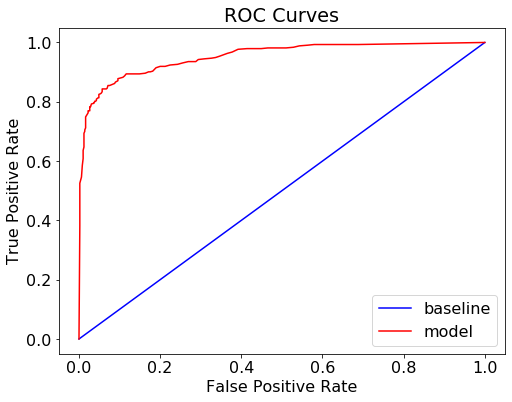

In [16]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Confusion matrix, without normalization
[[462  28]
 [ 68 366]]


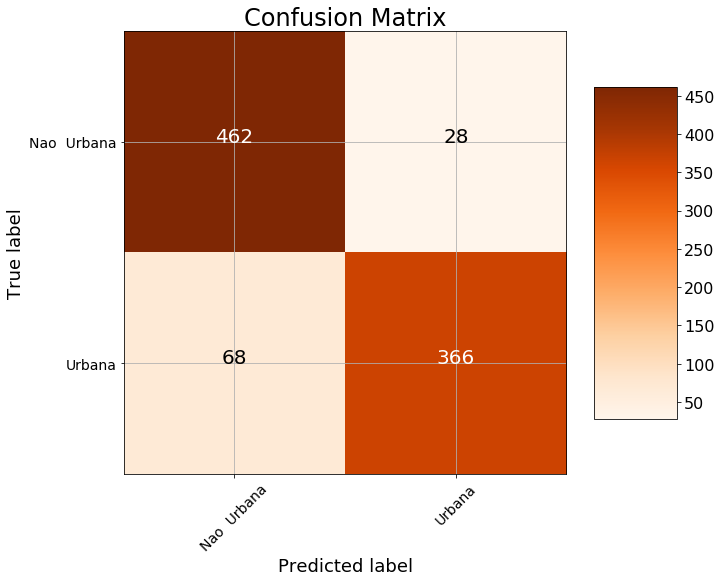

In [17]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Nao  Urbana', 'Urbana'],
                      title = 'Confusion Matrix')

In [18]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
2,blue,0.298558
0,red,0.187174
5,swir2,0.157982
1,green,0.147533
4,swir1,0.116300
3,nir,0.092453


In [19]:

from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = SEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=SEED)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [20]:
rs.best_params_

{'n_estimators': 83,
 'min_samples_split': 5,
 'max_leaf_nodes': 22,
 'max_features': 0.6,
 'max_depth': 8,
 'bootstrap': True}

In [21]:
best_model = rs.best_estimator_

In [22]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [23]:

n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 43
Average maximum depth 7


Recall Baseline: 1.0 Test: 0.85 Train: 0.87
Precision Baseline: 0.47 Test: 0.92 Train: 0.93
Roc Baseline: 0.5 Test: 0.95 Train: 0.97


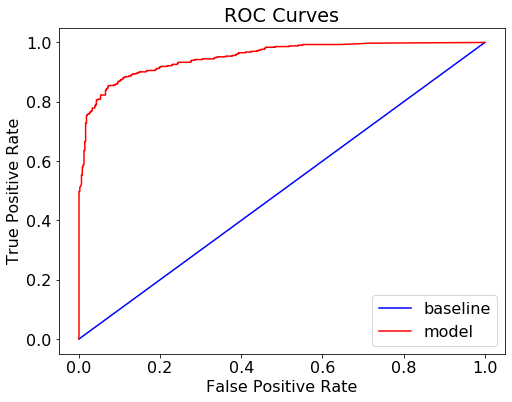

In [24]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [25]:
estimator = best_model.estimators_[0]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

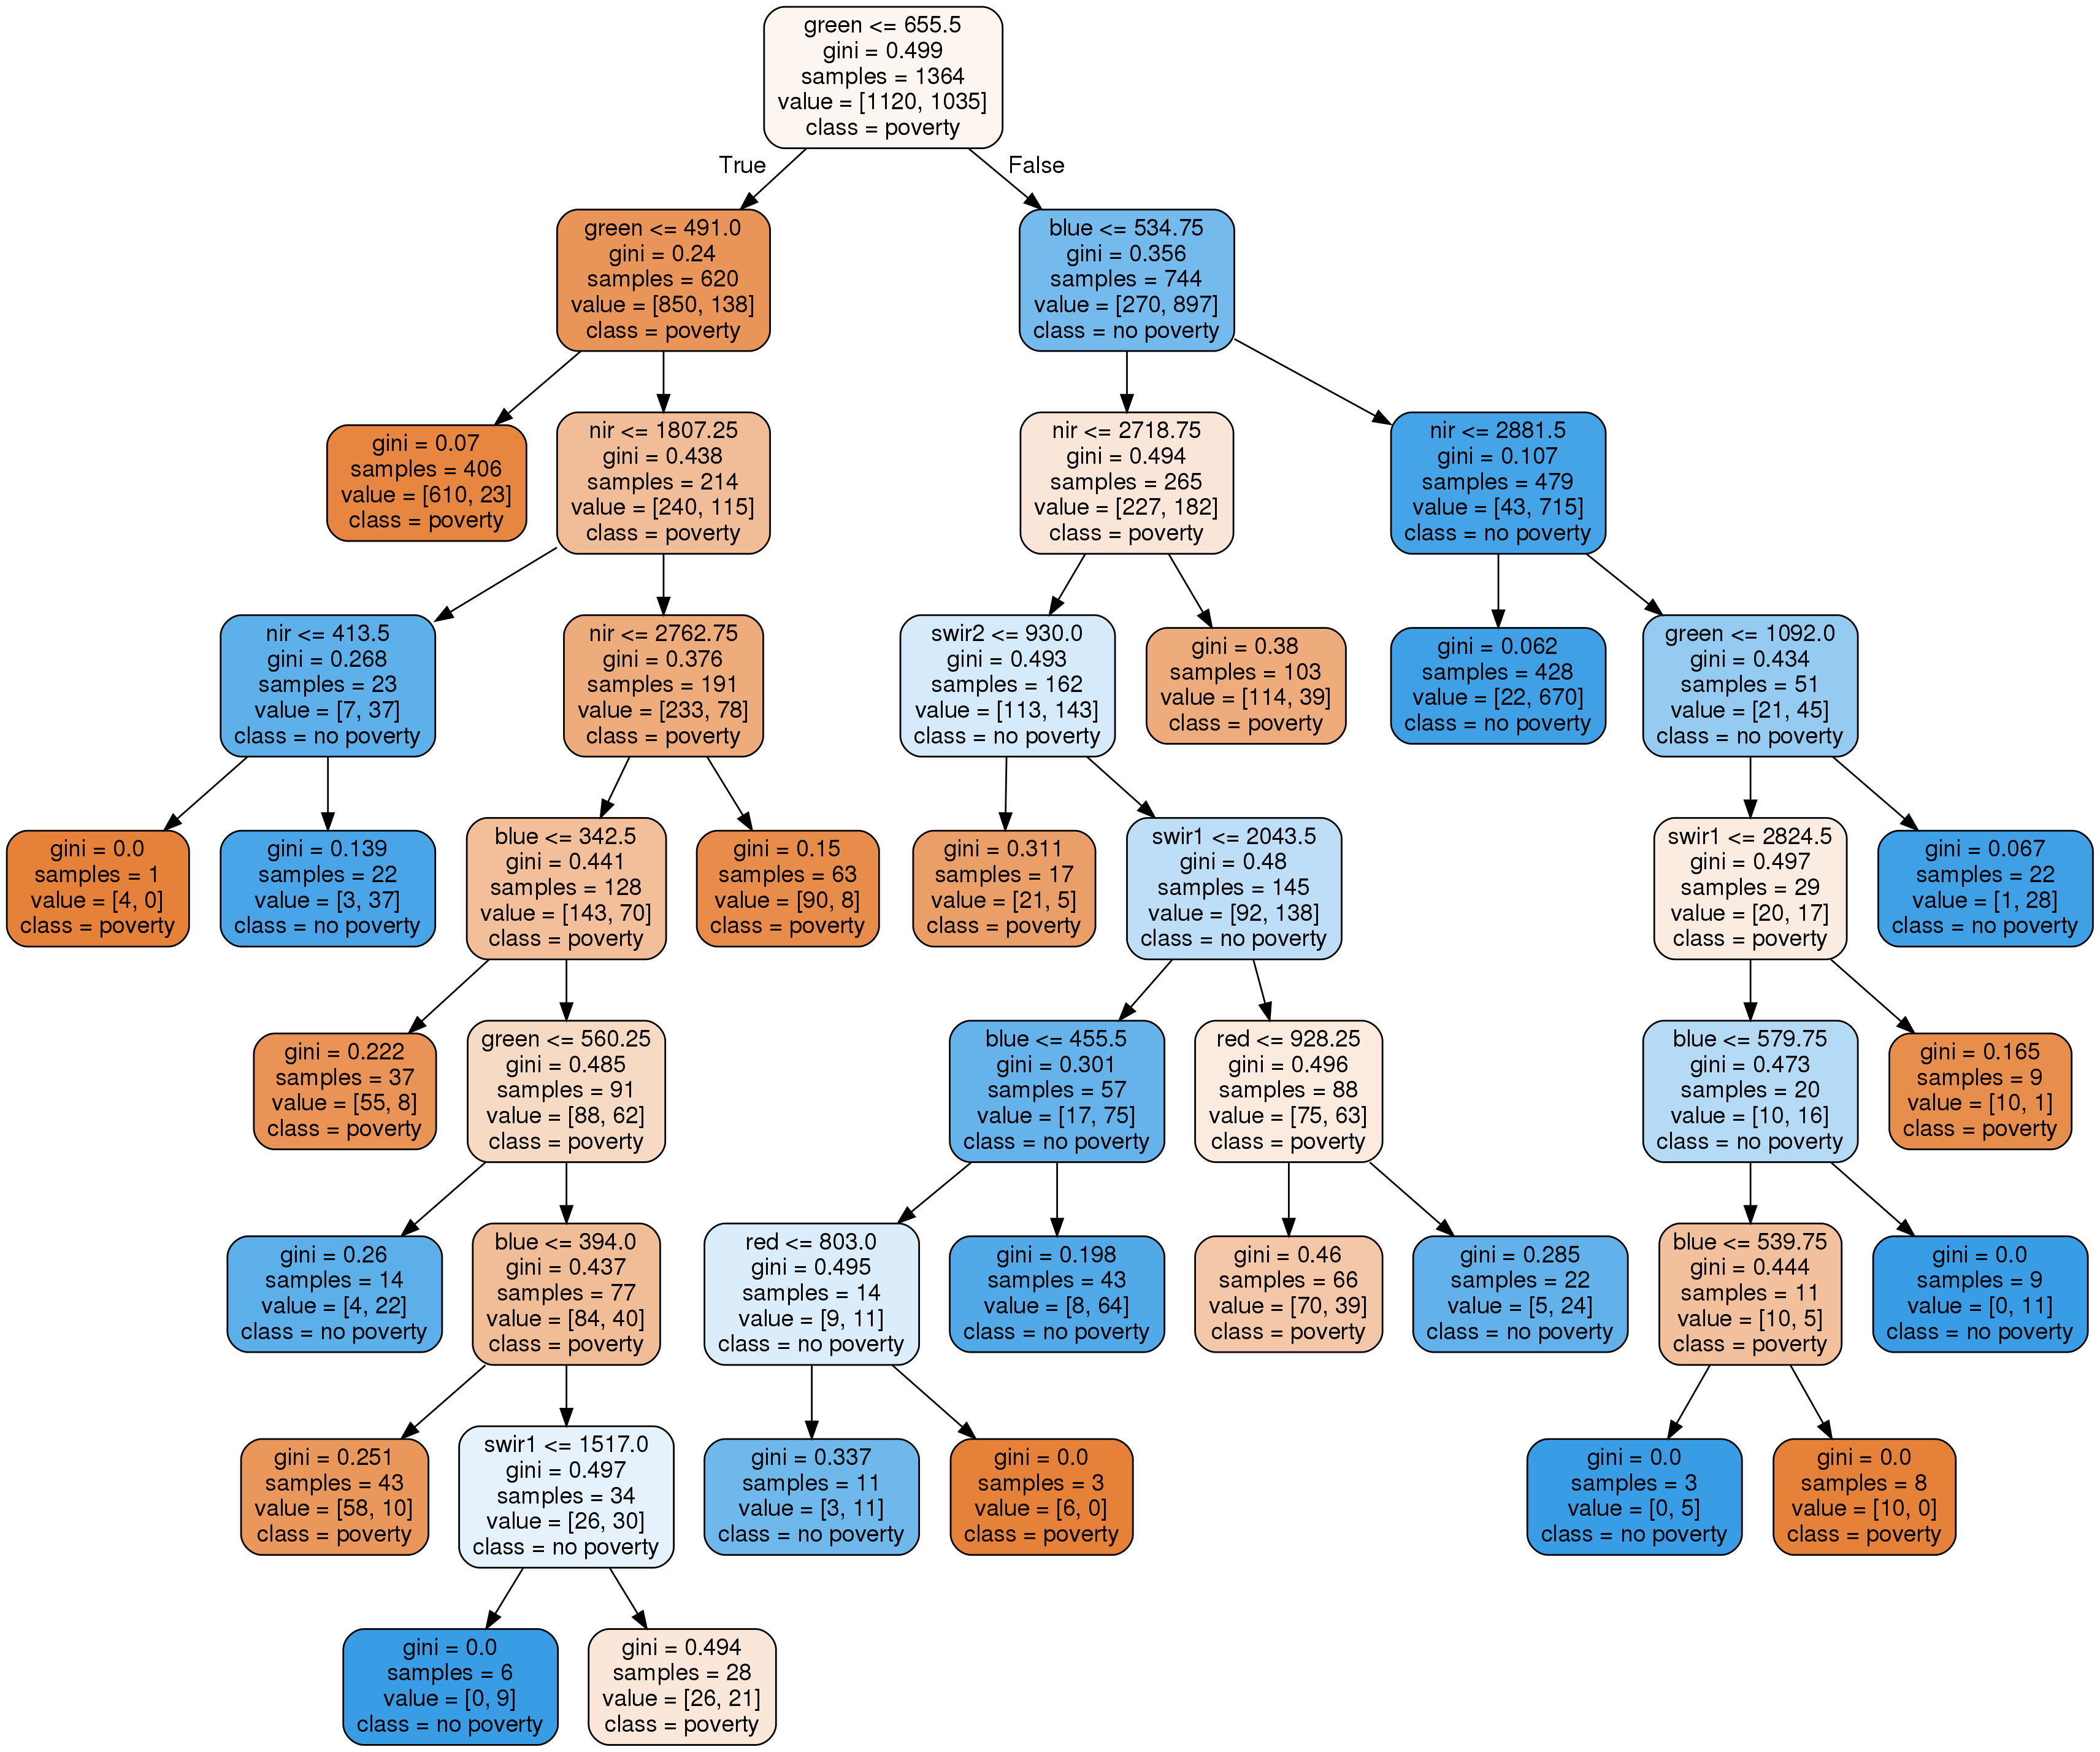

In [26]:
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

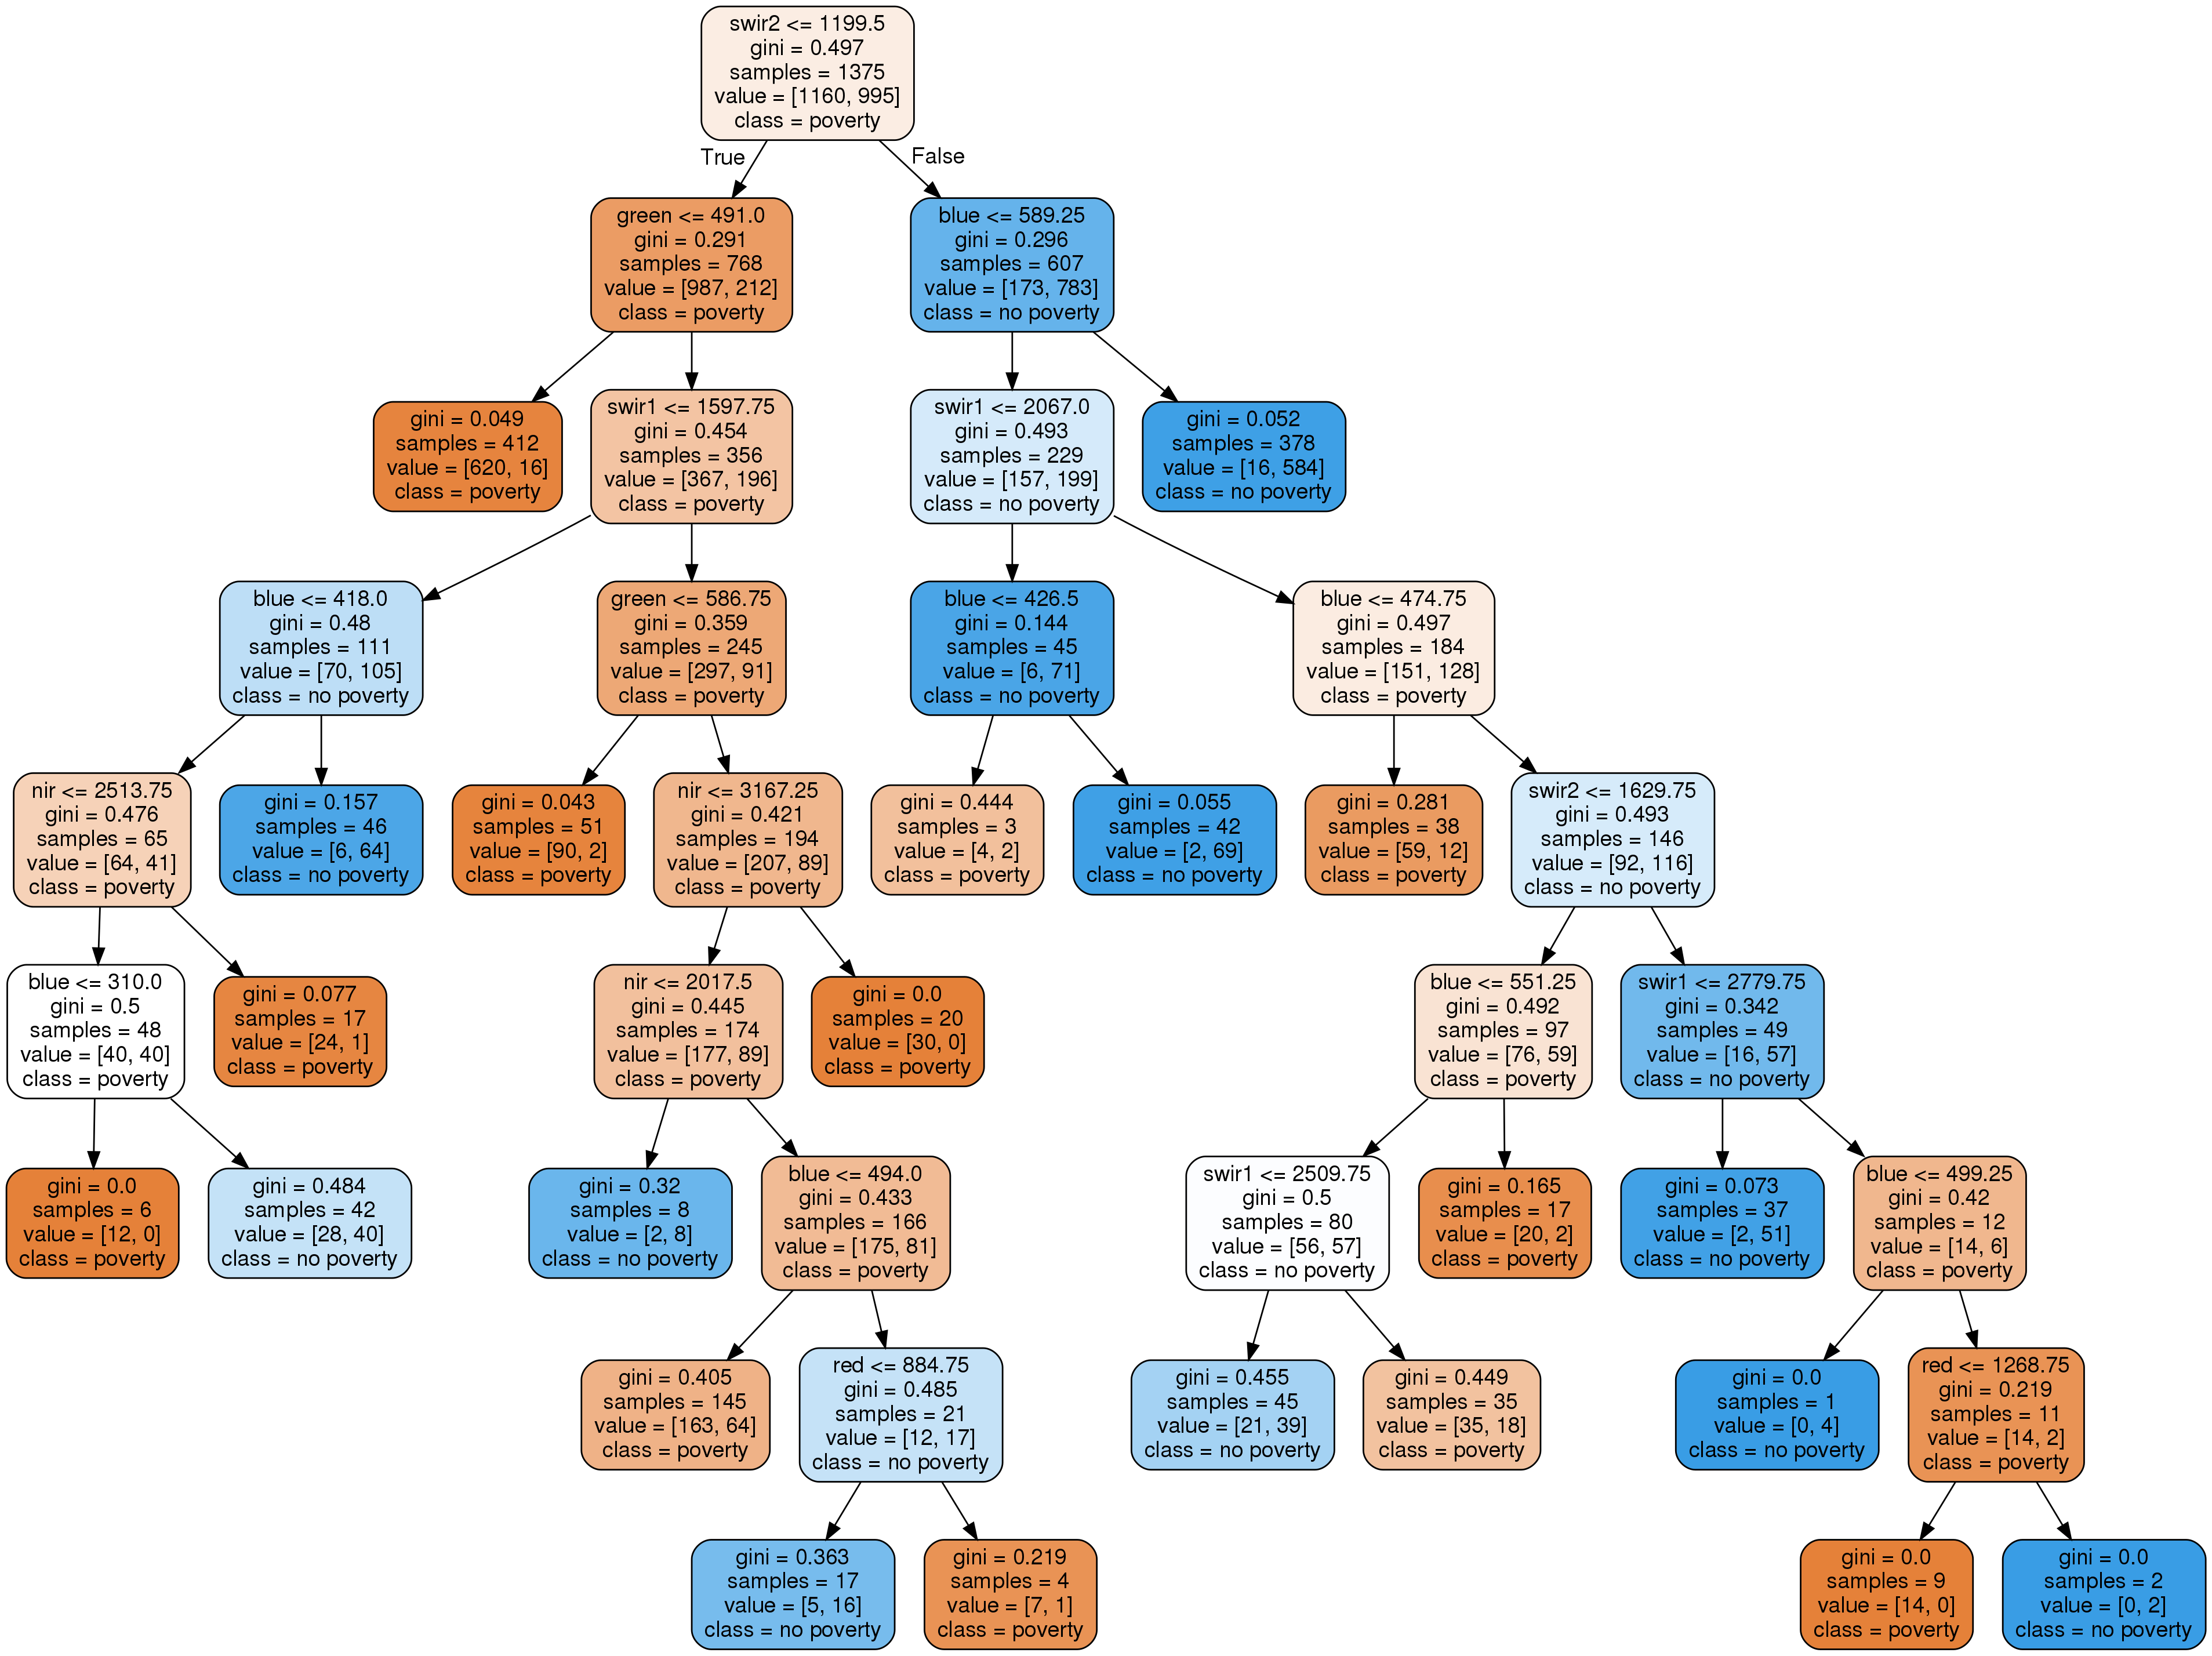

In [27]:
estimator = best_model.estimators_[80]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

In [28]:
estimator.decision_path

<bound method BaseDecisionTree.decision_path of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=0.6, max_leaf_nodes=22,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=783218067, splitter='best')>

In [29]:
len(best_model.estimators_)

83